In [1]:
import jax
from jax import numpy as jnp
import numpy as np
import mediapy
from tqdm import tqdm
import dataclasses

from scipy.interpolate import splprep, splev
from waymax import config as _config
from waymax import dataloader
from waymax import metrics
from waymax import datatypes
from waymax import dynamics
from waymax import env as _env
from waymax import agents
from waymax import visualization
from waymax.agents import actor_core
from waymax.dynamics.tricycle_model import TricycleModel
print(metrics.__file__)

d:\software\miniconda3\envs\waymax\lib\site-packages\waymax\metrics\__init__.py


In [2]:
def generate_racing_track(x, y, r, num_points=1000):
# Calculate tangent and normal vectors for each control point
    x_left = []
    y_left = []
    x_right = []
    y_right = []

    for i in range(len(x)):
        if i == 0:
            dx = x[i+1] - x[i]
            dy = y[i+1] - y[i]
        elif i == len(x) - 1:
            dx = x[i] - x[i-1]
            dy = y[i] - y[i-1]
        else:
            dx = x[i+1] - x[i-1]
            dy = y[i+1] - y[i-1]

        length = jnp.sqrt(dx**2 + dy**2)

        dx /= length
        dy /= length

        normal_x = -dy
        normal_y = dx

        width = r[i]  # Dynamic width based on r

        x_left.append(x[i] + normal_x * width / 2)
        y_left.append(y[i] + normal_y * width / 2)
        x_right.append(x[i] - normal_x * width / 2)
        y_right.append(y[i] - normal_y * width / 2)

    # Create new splines for left and right edges using the control points
    tck, _ = splprep([x, y], s=0, per=1)
    tck_left, _ = splprep([x_left, y_left], s=0, per=1)
    tck_right, _ = splprep([x_right, y_right], s=0, per=1)

    u_new = jnp.linspace(0, 1, num_points)
    x_center, y_center = splev(u_new, tck)
    x_left, y_left = splev(u_new, tck_left)
    x_right, y_right = splev(u_new, tck_right)

    dx_center = jnp.diff(x_center)
    dy_center = jnp.diff(y_center)
    segment_lengths = jnp.sqrt(dx_center**2 + dy_center**2)
    cumulative_length = jnp.cumsum(segment_lengths)
    cumulative_length = jnp.insert(cumulative_length, 0, 0)
    normalized_length = cumulative_length / cumulative_length[-1]

    dx_left = jnp.diff(x_left)
    dy_left = jnp.diff(y_left)
    dx_right = jnp.diff(x_right)
    dy_right = jnp.diff(y_right)
    
    # To keep the directions array the same length as the other arrays, append the last direction
    dx_center = jnp.append(dx_center, dx_center[-1])
    dy_center = jnp.append(dy_center, dy_center[-1])
    dx_left = jnp.append(dx_left, dx_left[-1])
    dy_left = jnp.append(dy_left, dy_left[-1])
    dx_right = jnp.append(dx_right, dx_right[-1])
    dy_right = jnp.append(dy_right, dy_right[-1])

    # normalize the directions
    dx_center /= jnp.sqrt(dx_center**2 + dy_center**2)
    dy_center /= jnp.sqrt(dx_center**2 + dy_center**2)
    dx_left /= jnp.sqrt(dx_left**2 + dy_left**2)
    dy_left /= jnp.sqrt(dx_left**2 + dy_left**2)
    dx_right /= jnp.sqrt(dx_right**2 + dy_right**2)
    dy_right /= jnp.sqrt(dx_right**2 + dy_right**2)

    x_points = jnp.concatenate([x_center, x_left, x_right])
    y_points = jnp.concatenate([y_center, y_left, y_right])
    dir_x = jnp.concatenate([dx_center, -dx_left, dx_right])   # different directions for left and right boundary ????
    dir_y = jnp.concatenate([dy_center, -dy_left, dy_right])
    point_types = jnp.ones(num_points)
    point_types = jnp.concatenate([point_types, point_types*15, point_types*15]) # 1: centerline, 15: road boundary

    roadgraph_points = datatypes.RoadgraphPoints(
        x=x_points,
        y=y_points,
        z=jnp.zeros_like(x_points),
        dir_x=dir_x,
        dir_y=dir_y,
        dir_z=jnp.zeros_like(x_points),
        types=point_types,
        ids=jnp.ones_like(x_points),   # different ids for left and right boundary ??
        valid=jnp.ones_like(x_points, dtype=jnp.bool_),
    )

    return roadgraph_points, jnp.array(x_center), jnp.array(y_center) ,cumulative_length

In [3]:
class TrackControlPoints:
    # Control points for the racing track, can be modified to create different tracks

    x = [30.3914, 34.5985, 37.9136, 41.6058, 44.124, 45.9188, 47.1959, 46.7351, 47.377, 47.6532, 46.6591, 
         46.5467, 47.6512, 50.0049, 52.5865, 53.9889, 54.3171, 54.2784, 53.4375, 52.333, 52.4365, 52.7472, 
         52.8369, 55.1218, 58.2352, 61.1966, 63.6817, 63.8858, 63.6888, 62.9846, 61.3693, 60.3086, 61.1369, 
         62.628, 63.8217, 63.6216, 63.6008, 60.7928, 57.7416, 55.1978, 52.4077, 50.7395, 48.7177, 46.7472, 
         44.5036, 42.2313, 40.4915, 39.5135, 38.3055, 36.587, 34.6551, 32.3964, 30.7208, 29.1654, 27.7528, 
         26.6793, 24.522, 22.221, 19.7474, 19.1721, 19.4022, 20.2766, 21.5824, 20.4607, 19.5942, 18.8348, 
         17.8684, 17.3219, 17.6429, 19.1694, 20.7179, 24.2734, 27.8213]
    y = [20.1282, 20.1528, 20.2138, 20.2842, 20.7843, 22.4755, 24.7191, 27.2454, 29.406, 31.7393, 34.3911, 
         36.9626, 39.0335, 39.6952, 39.4935, 37.7643, 35.5898, 33.2763, 30.4582, 27.3863, 25.0047, 22.5748, 
         20.3727, 19.9309, 19.6341, 19.5305, 20.4003, 23.1452, 25.8114, 27.7581, 29.2077, 32.5508, 35.243, 
         37.1483, 39.4283, 41.6718, 44.6677, 46.0382, 46.4869, 45.5216, 45.234, 45.2915, 46.1012, 46.1193, 
         45.9755, 45.6591, 44.8517, 43.0108, 41.8028, 40.0157, 38.8012, 39.2758, 40.0983, 41.2595, 43.9097, 
         45.7592, 46.6796, 46.7659, 46.1906, 43.9183, 42.0775, 39.5521, 37.8896, 35.5483, 33.2801, 30.8985, 
         28.4824, 25.8132, 22.2225, 20.5131, 19.6407, 19.9199, 20.0432]
    r = [4.6, 4.6, 4.6, 4.6, 4.0, 3.0, 3.0, 3.0, 3.0, 1.6, 2.4, 4.6, 5.6, 4.98, 5.4, 5.4, 3.0, 2.4, 2.2, 
         2.4, 2.4, 4.4, 4.4, 4.0, 3.0, 3.0, 4.4, 4.0, 3.4, 3.8, 3.4, 2.0, 3.6, 5.0, 4.0, 4.0, 6.0, 4.8, 4.0,
         2.0, 1.6, 2.0, 3.6, 4.4, 5.0, 6.0, 6.0, 5.0, 3.6, 3.4, 4.0, 3.0, 2.6, 3.0, 3.0, 3.0, 3.6, 3.6, 5.0, 
         4.8, 2.0, 1.6, 3.8, 2.8, 2.0, 1.8, 2.8, 3.0, 3.0, 4.6, 4.4, 4.4, 4.6]

In [4]:
class GoKartGeometry:
  l1: float = 0.72 # Distance from cog to front tires
  l2: float = 0.47 # Distance from cog to rear tires
  w1: float = 0.94 # Distance between front Tires
  w2: float = 1.08 # Distance between rear Tires
  back2backaxle: float = 0.23 # Distance from the rear of the gokart to the back axle
  frontaxle2front: float = 0.33 # Distance from the front axle to the front of the kart
  wheel2border: float = 0.18 # Side distance between center of the wheel and external frame
  F2n: float = l1/(l1 + l2) # Normal force at the rear axle "portion of Mass supported by rear tire"

class TricycleParams:
  Iz: float = 0.7 # Inertia around the z axis
  REG_: float = 0.5 # Regularization factor
  
class PajieckaParams:
  class front_paj:
    B: float = 17.17
    C: float = 1.26
    D: float = 0.8
    E: float = 0.42
  class rear_paj:
    B: float = 13.02
    C: float = 1.27
    D: float = 0.97
    E: float = 0.21


In [5]:
# test the track generation function
_, x_center, y_center, cumulative_length = generate_racing_track(TrackControlPoints.x, TrackControlPoints.y, TrackControlPoints.r, num_points=1000)
print(x_center[0],y_center[0]) # the first point is also the last point
print(x_center[-1],y_center[-1])
print(x_center[-2],y_center[-2])
distance = jnp.sqrt((x_center[1:]-x_center[:-1])**2+(y_center[1:]-y_center[:-1])**2)  # distance between two centerline points
print(distance[:20])
print(x_center.shape, cumulative_length.shape)
print(cumulative_length[0])
print(cumulative_length[-1])

30.3914 20.1282
30.3914 20.1282
30.206045 20.131584
[0.18550259 0.18561755 0.18573026 0.18584053 0.18594632 0.18604943
 0.18614587 0.18624125 0.18633166 0.18641508 0.18649708 0.18657188
 0.18664703 0.18671474 0.186775   0.18683533 0.18688802 0.1869369
 0.18697795 0.18701501]
(1000,) (1000,)
0.0
187.8065


In [6]:
# create a GoKartSimState object with the generated track
# Since we don't have a log trajectory, we set the first point of the log trajectory to the first point of the centerline and
# the last point of the log trajectory to the second last point of the centerline, which will be used to calculate the progress (see metric sdc_progression)
# We use the centerline as the sdc path (reference path) 
def create_init_state(num_timesteps = 200):
    trajectory = datatypes.GoKartTrajectory.zeros((1, num_timesteps))  # 1 object, 200 time steps
    sim_trajectory = trajectory
    log_trajectory = trajectory
    sim_trajectory.length = jnp.ones_like(sim_trajectory.length) * 1.5
    sim_trajectory.width = jnp.ones_like(sim_trajectory.width)
    sim_trajectory.height = jnp.ones_like(sim_trajectory.height)
    sim_trajectory.valid = sim_trajectory.valid.at[0,0].set(True)
    # sim_trajectory.valid = jnp.ones_like(sim_trajectory.valid, dtype=jnp.bool_)
    sim_trajectory.x = sim_trajectory.x.at[0, 0].set(TrackControlPoints.x[0])
    sim_trajectory.y = sim_trajectory.y.at[0, 0].set(TrackControlPoints.y[0])
    traffic_light = datatypes.TrafficLights(x=jnp.zeros((0, num_timesteps)), y=jnp.zeros((0, num_timesteps)), z = jnp.zeros((0, num_timesteps)), 
                                            state=jnp.zeros((0, num_timesteps)), lane_ids=jnp.zeros((0, num_timesteps), dtype=jnp.int32), valid=jnp.ones((0, num_timesteps), dtype=jnp.bool_))
    metadata = datatypes.ObjectMetadata(ids=jnp.array([0]), object_types=jnp.array([1]), is_sdc=jnp.array([True]), is_modeled=jnp.array([False]), 
                                        is_valid=jnp.array([True]), objects_of_interest=jnp.array([False]), is_controlled=jnp.array([True]))
    timestep = 0
    
    roadgraph_points, x_center, y_center, cumulative_length = generate_racing_track(TrackControlPoints.x, TrackControlPoints.y, TrackControlPoints.r, num_points=1000)

    x_path = jnp.expand_dims(x_center[:-1], axis=-2) # shape(num_paths=1, num_points_per_path)
    y_path = jnp.expand_dims(y_center[:-1], axis=-2) # the last point is the first point
    dx_path = jnp.diff(x_path)
    dy_path = jnp.diff(y_path)
    dx_path = jnp.append(dx_path, dx_path[-1])
    dy_path = jnp.append(dy_path, dy_path[-1])
    dx_path /= jnp.sqrt(dx_path**2 + dy_path**2)
    dy_path /= jnp.sqrt(dx_path**2 + dy_path**2)
    dx_path = jnp.expand_dims(dx_path, axis=-2)
    dy_path = jnp.expand_dims(dy_path, axis=-2)
    sdc_path = datatypes.GoKartPaths(
        x = x_path,
        y = y_path,
        z = jnp.zeros_like(x_path),
        dir_x = dx_path,
        dir_y = dy_path,
        ids = jnp.zeros_like(x_path, dtype=jnp.int32),
        valid=jnp.ones_like(x_path, dtype=jnp.bool_),
        arc_length= jnp.expand_dims(cumulative_length, axis=-2),
        on_route=jnp.ones((1, 1), dtype=jnp.bool_)
    )

    log_trajectory.x = log_trajectory.x.at[0, -1].set(x_center[-2])
    log_trajectory.y = log_trajectory.y.at[0, -1].set(y_center[-2])

    return datatypes.GoKartSimState(sim_trajectory=sim_trajectory,log_trajectory=trajectory, log_traffic_light=traffic_light, 
                                    object_metadata=metadata, timestep=timestep, roadgraph_points=roadgraph_points, sdc_paths=sdc_path)

In [7]:
viz_cfg={
  "front_x": 20.0,
  "back_x":  20.0,
  "front_y":  20.0,
  "back_y": 20.0,
  "px_per_meter": 15.0
}

[[30.3914   20.1282  ]
 [30.57688  20.125313]
 [30.762482 20.122925]
 [30.948202 20.121016]
 [31.134037 20.119566]
 [31.31998  20.11856 ]
 [31.50603  20.117975]
 [31.692175 20.117796]
 [31.878416 20.118002]
 [32.064747 20.118572]]


""

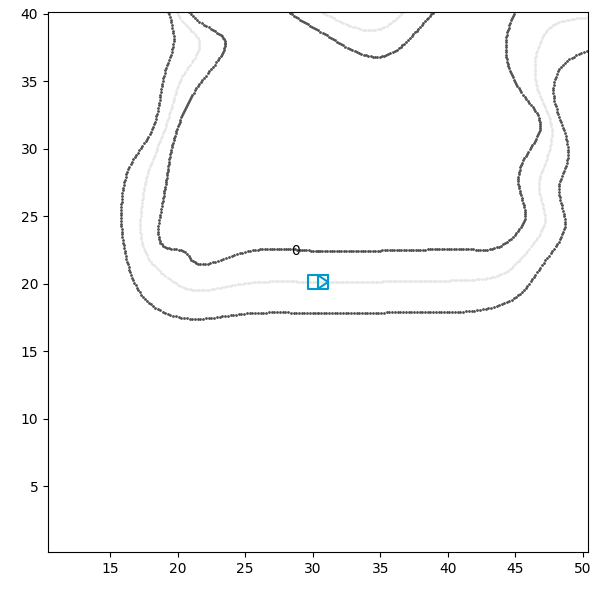

In [8]:
state = create_init_state(num_timesteps=200)
# test the state object
print(state.sdc_paths.xy[0,:10])
# print(state.sim_trajectory.valid)
# print(state.sim_trajectory.xy[0,:10])
img=visualization.plot_simulator_state(state, use_log_traj=False, viz_config=viz_cfg)
mediapy.show_image(img)

In [9]:
# for multiagent env
# dummy_action = actor_core.WaymaxActorOutput(actor_state=None, 
#                                      action = datatypes.Action(data=jnp.array([[0.0, 0.2, 0.2]]), valid=jnp.array([[True]])), 
#                                      is_controlled=jnp.array([True]))

# for planning agent env
dummy_action = actor_core.WaymaxActorOutput(actor_state=None, 
                                     action = datatypes.Action(data=jnp.array([0.5, 0.2, 0.2]), valid=jnp.array([True])), 
                                     is_controlled=jnp.array([True]))

In [10]:
# dynamics_model = dynamics.StateDynamics()
dynamics_model = TricycleModel(gk_geometry=GoKartGeometry(), model_params=TricycleParams(), paj_params=PajieckaParams(), dt=0.1)

# Expect users to control all valid object in the scene.
# env = _env.MultiAgentEnvironment(
#     dynamics_model=dynamics_model,
#     config=dataclasses.replace(
#         _config.EnvironmentConfig(),
#         max_num_objects=1,
#         init_steps = 1
#     ),
# )

env1 = _env.GokartRacingEnvironment(
    dynamics_model=dynamics_model,
    config=dataclasses.replace(
        _config.EnvironmentConfig(),
        max_num_objects=1,
        init_steps = 1  # => state.timestep = 0
    ),
)

In [11]:
# dynamics_model = dynamics.StateDynamics()
# actor = agents.create_constant_speed_actor(
#     speed=2.0,
#     dynamics_model=dynamics_model,
#     is_controlled_func=lambda state: jnp.array([True]),
# )

In [12]:
jit_step = jax.jit(env1.step)

# jit_select_action = jax.jit(actor.select_action)

In [13]:
states = [env1.reset(state)]
metrics_list = []

for i in range(states[0].remaining_timesteps):
  current_state = states[-1]

  # action = jit_select_action({}, current_state, None, None)

  next_state = jit_step(current_state, action = dummy_action.action)
  # metric_dict = metrics.run_metrics(next_state, metrics_config)

  states.append(next_state)
  # metrics_list.append(metric_dict)

In [14]:
len(states)

200

In [15]:
# test the observation function
print(env1.observe(states[50])) # use normalized observation??   velocity in local frame

[1.9085417e+00 7.5140804e-02 9.1727710e-01 7.7313326e-02 1.2442732e-01
 1.4689694e-01 1.3234987e-03 2.9218253e-02 5.0488789e-02 6.3267954e-02
 6.2678941e-02]


In [16]:
# test metrics/rewards calculation
metrics_config = dataclasses.replace(_config.MetricsConfig(),metrics_to_run=("offroad", "sdc_progression"))
metric_dict1 = metrics.run_metrics(states[50], metrics_config)
print(states[-1].sim_trajectory.xy[0,50])
metric_dict2 = metrics.run_metrics(states[90], metrics_config)
print(states[-1].sim_trajectory.xy[0,90])

print(metric_dict1)
print(metric_dict2)

## what happens if the car start a new lap : reset the state

[34.48439  22.399818]
[32.20394 29.26053]
{'offroad': MetricResult(value=Array([1.], dtype=float32), valid=Array([ True], dtype=bool)), 'sdc_progression': MetricResult(value=Array(0.02186217, dtype=float32), valid=Array(True, dtype=bool))}
{'offroad': MetricResult(value=Array([1.], dtype=float32), valid=Array([ True], dtype=bool)), 'sdc_progression': MetricResult(value=Array(0.00991264, dtype=float32), valid=Array(True, dtype=bool))}


In [17]:
print(states[1].log_trajectory.shape)
print(states[-1].log_trajectory.xy[0,:3])
print(states[-1].log_trajectory.xy[0,-1])
print(states[-1].log_trajectory.valid[0,-1]) # check if the last log point should be valid??
print(states[-1].sim_trajectory.vel_xy[0,130:140])

(1, 200)
[[30.3914 20.1282]
 [ 0.      0.    ]
 [ 0.      0.    ]]
[30.206045 20.131584]
False
[[-1.2414018  -3.280484  ]
 [-1.1255374  -3.4279473 ]
 [-0.9935027  -3.577093  ]
 [-0.8441399  -3.726526  ]
 [-0.6763247  -3.874626  ]
 [-0.48899746 -4.0017896 ]
 [-0.26467323 -4.036374  ]
 [ 0.00543306 -4.06175   ]
 [ 0.32112262 -4.069514  ]
 [ 0.675808   -4.025909  ]]


In [18]:
imgs = []
for state in states:
  imgs.append(visualization.plot_simulator_state(state, use_log_traj=False,viz_config=viz_cfg))
# imgs = [visualization.plot_simulator_state(states[0], use_log_traj=False)]
# print(states[0].object_metadata)
mediapy.show_video(imgs, fps=10)

In [19]:
# similar setup for multiagent env

def create_init_state_2agents():
    trajectory = datatypes.GoKartTrajectory.zeros((2, 100))  # 2 object, 100 time steps
    sim_trajectory = trajectory
    log_trajectory = trajectory
    sim_trajectory.length = jnp.ones_like(sim_trajectory.length) * 1.5
    sim_trajectory.width = jnp.ones_like(sim_trajectory.width)
    sim_trajectory.height = jnp.ones_like(sim_trajectory.height)
    sim_trajectory.valid = sim_trajectory.valid.at[:,0].set(True)
    # sim_trajectory.valid = jnp.ones_like(sim_trajectory.valid, dtype=jnp.bool_)
    sim_trajectory.x = sim_trajectory.x.at[0, 0].set(TrackControlPoints.x[0])
    sim_trajectory.y = sim_trajectory.y.at[0, 0].set(TrackControlPoints.y[0])
    sim_trajectory.x = sim_trajectory.x.at[1, 0].set(TrackControlPoints.x[-1])
    sim_trajectory.y = sim_trajectory.y.at[1, 0].set(TrackControlPoints.y[-1])
    traffic_light = datatypes.TrafficLights(x=jnp.zeros((0, 100)), y=jnp.zeros((0, 100)), z = jnp.zeros((0, 100)), 
                                            state=jnp.zeros((0, 100)), lane_ids=jnp.zeros((0, 100), dtype=jnp.int32), valid=jnp.ones((0, 100), dtype=jnp.bool_))
    metadata = datatypes.ObjectMetadata(ids=jnp.array([0, 1]), object_types=jnp.array([1]), is_sdc=jnp.array([True, False]), is_modeled=jnp.array([False, False]), 
                                        is_valid=jnp.array([True, True]), objects_of_interest=jnp.array([False, False]), is_controlled=jnp.array([True, False]))
    timestep = 0
    num_points = 1000
    roadgraph_points, x_center, y_center, cumulative_length = generate_racing_track(TrackControlPoints.x, TrackControlPoints.y, TrackControlPoints.r, num_points=1000)

    x_path = jnp.expand_dims(x_center[:-1], axis=-2) # shape(num_paths=1, num_points_per_path)
    y_path = jnp.expand_dims(y_center[:-1], axis=-2) # the last point is the first point
    dx_path = jnp.diff(x_path)
    dy_path = jnp.diff(y_path)
    dx_path = jnp.append(dx_path, dx_path[-1])
    dy_path = jnp.append(dy_path, dy_path[-1])
    dx_path /= jnp.sqrt(dx_path**2 + dy_path**2)
    dy_path /= jnp.sqrt(dx_path**2 + dy_path**2)
    dx_path = jnp.expand_dims(dx_path, axis=-2)
    dy_path = jnp.expand_dims(dy_path, axis=-2)
    sdc_path = datatypes.GoKartPaths(
        x = x_path,
        y = y_path,
        z = jnp.zeros_like(x_path),
        dir_x = dx_path,
        dir_y = dy_path,
        ids = jnp.zeros_like(x_path, dtype=jnp.int32),
        valid=jnp.ones_like(x_path, dtype=jnp.bool_),
        arc_length= jnp.expand_dims(cumulative_length, axis=-2),
        on_route=jnp.ones((1, 1), dtype=jnp.bool_)
    )

    log_trajectory.x = log_trajectory.x.at[0, -1].set(x_center[-2])
    log_trajectory.y = log_trajectory.y.at[0, -1].set(y_center[-2])

    return datatypes.GoKartSimState(sim_trajectory=sim_trajectory,log_trajectory=trajectory, log_traffic_light=traffic_light, 
                                    sdc_paths=sdc_path, object_metadata=metadata, timestep=timestep, roadgraph_points=roadgraph_points)

In [20]:
static_agent = [agents.FrozenSimPolicy(is_controlled_func=lambda state: jnp.array([False, True]))] # the second object is controlled by this agent
static_agent_param = [jnp.empty((1,))] # placeholder

In [21]:
env2 = _env.PlanningAgentEnvironment(
    dynamics_model=dynamics_model,
    config=dataclasses.replace(
        _config.EnvironmentConfig(),
        max_num_objects = 2,
        init_steps = 1  # equal to state.timestep = 0
    ),
    sim_agent_actors=static_agent,
    sim_agent_params=static_agent_param
)

In [22]:
state2 = create_init_state_2agents()
jit_step = jax.jit(env2.step)
states = [env2.reset(state2)]

In [23]:
for _ in range(states[0].remaining_timesteps):
  current_state = states[-1]

  # action = jit_select_action({}, current_state, None, None)
  
  next_state = jit_step(current_state, action = dummy_action.action)

  states.append(next_state)

In [24]:
imgs = []
for state in states:
  imgs.append(visualization.plot_simulator_state(state, use_log_traj=False,viz_config=viz_cfg))
# imgs = [visualization.plot_simulator_state(states[0], use_log_traj=False)]
# print(states[0].object_metadata)
mediapy.show_video(imgs, fps=10)